In [4]:
import cv2
import os

In [44]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
# try reducing the size of the video

def get_emotion_label(filename):
    parts = filename.split('-')
    emotion_label = int(parts[2])
    emotions = {
        1: "neutral", 2: "calm", 3: "happy", 4: "sad",
        5: "angry", 6: "fearful", 7: "disgust", 8: "surprised"
    }
    return emotions.get(emotion_label, "unknown")

def get_frames(video_path, output_dir, frame_rate=1, network_size=(48,48)):
    filename = os.path.basename(video_path)
    emotion_label = get_emotion_label(filename)
    
    #create directory for emotion
    emotion_dir = os.path.join(output_dir, emotion_label)
    os.makedirs(emotion_dir, exist_ok=True)
    
    #read the video
    capture = cv2.VideoCapture(video_path)
    frame_count=0
    success=True
    
    #set frame interval based on the frame rate
    fps = int(capture.get(cv2.CAP_PROP_FPS))
    frame_interval = int(fps / frame_rate)
    
    while success:
        success, frame = capture.read()
        if not success:
            break
        
        compressed_frame = cv2.resize(frame, (0, 0), fx=0.25, fy=0.25)  # Scale down by 25%
        gray_frame = cv2.cvtColor(compressed_frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
        
        if len(faces) > 0:
            x, y, w, h = faces[0]  # Use the first detected face
            face = gray_frame[y:y+h, x:x+w]  # Crop the face region
            face_resized = cv2.resize(face, network_size)  # Resize to a standard size for the network
        else:
            print("No face detected in this frame.")
        #save the frame at the specified time interval
        if frame_count % frame_interval == 0:
            frame_filename = f"{filename.split('.')[0]}_frame{frame_count}.jpg"
            frame_path = os.path.join(emotion_dir, frame_filename)
            cv2.imwrite(frame_path, face_resized)
            
        frame_count += 1
        
    capture.release()
    print(f"Extracted frames from {filename} into {emotion_dir}")
    
def process_all_actors(base_dir, output_dir):
    actors = [actor for actor in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, actor))]
    
    for actor in actors:
        actor_path = os.path.join(base_dir, actor)
        videos = [f for f in os.listdir(actor_path) if f.endswith(".mp4")]
        
        for video in videos:
            video_path = os.path.join(actor_path, video)
            get_frames(video_path, output_dir)

In [45]:
video_folder = "C:\\Users\\Lewis\\OneDrive - University of Glasgow\\Year 4\\Facial Emotion Recognition Project\\Actor_01"
all_actors_laptop = "C:\\Users\\Lewis\\OneDrive - University of Glasgow\\Year 4\\Facial Emotion Recognition Project\\Actors"
all_actors_pc = "C:\\Users\\paulb\\OneDrive - University of Glasgow\\Year 4\\Facial Emotion Recognition Project\\Actors"
output_folder = "C:\\Users\\paulb\\OneDrive - University of Glasgow\\Year 4\\Facial Emotion Recognition Project\\datasetAllActors"

process_all_actors(all_actors_pc, output_folder)

Extracted frames from 01-02-01-01-01-01-01.mp4 into C:\Users\paulb\OneDrive - University of Glasgow\Year 4\Facial Emotion Recognition Project\datasetAllActors\neutral
Extracted frames from 01-02-01-01-01-02-01.mp4 into C:\Users\paulb\OneDrive - University of Glasgow\Year 4\Facial Emotion Recognition Project\datasetAllActors\neutral
Extracted frames from 01-02-01-01-02-01-01.mp4 into C:\Users\paulb\OneDrive - University of Glasgow\Year 4\Facial Emotion Recognition Project\datasetAllActors\neutral
Extracted frames from 01-02-01-01-02-02-01.mp4 into C:\Users\paulb\OneDrive - University of Glasgow\Year 4\Facial Emotion Recognition Project\datasetAllActors\neutral
Extracted frames from 01-02-02-01-01-01-01.mp4 into C:\Users\paulb\OneDrive - University of Glasgow\Year 4\Facial Emotion Recognition Project\datasetAllActors\calm
Extracted frames from 01-02-02-01-01-02-01.mp4 into C:\Users\paulb\OneDrive - University of Glasgow\Year 4\Facial Emotion Recognition Project\datasetAllActors\calm
Extr

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
import re

class CustomImageFolder(datasets.ImageFolder):
    def __init__(self, root, transform=None):
        super(CustomImageFolder, self).__init__(root, transform)
        self.actor_ids = [self._extract_actor_id(path) for path, _ in self.samples]

    def _extract_actor_id(self, path):
        filename = os.path.basename(path)
        match = re.search(r'-(\d+)_frame', filename)
        return int(match.group(1)) if match else None

    def get_actor_ids(self):
        return self.actor_ids

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), 
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (0.5,))
])

data_dir = "C:\\Users\\paulb\\OneDrive - University of Glasgow\\Year 4\\Facial Emotion Recognition Project\\dataset"
data_dir_all = "C:\\Users\\paulb\\OneDrive - University of Glasgow\\Year 4\\Facial Emotion Recognition Project\\datasetAllActors"

full_dataset = CustomImageFolder(data_dir_all, transform=transform)




In [59]:
from sklearn.model_selection import GroupKFold
import numpy as np

actor_ids = np.array(full_dataset.get_actor_ids())

# Initialize Leave-One-Actor-Out Cross-Validation
group_kfold = GroupKFold(n_splits=len(np.unique(actor_ids)))

# Loop through splits
for train_idx, test_idx in group_kfold.split(np.zeros(len(actor_ids)), groups=actor_ids):
    # Create subsets for training and testing
    train_subset = Subset(full_dataset, train_idx)
    test_subset = Subset(full_dataset, test_idx)
    
    # Create DataLoaders
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)
    
    print(f"Training on actors: {np.unique(actor_ids[train_idx])}")
    print(f"Testing on actor: {np.unique(actor_ids[test_idx])}")
    
    # Train and evaluate your model here

Training on actors: [1 3 4 5 6]
Testing on actor: [2]
Training on actors: [1 2 3 4 6]
Testing on actor: [5]
Training on actors: [1 2 3 4 5]
Testing on actor: [6]
Training on actors: [1 2 4 5 6]
Testing on actor: [3]
Training on actors: [2 3 4 5 6]
Testing on actor: [1]
Training on actors: [1 2 3 5 6]
Testing on actor: [4]


In [ ]:
train_size = int(0.7*len(full_dataset))
test_size = int(0.15*len(full_dataset))
val_size = len(full_dataset) - train_size - test_size
train_data, val_data, test_data = random_split(full_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [74]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleEmotionNN(nn.Module):
    def __init__(self):
        super(SimpleEmotionNN, self).__init__()
        
        #setting up our layers for the NN all the pixels down to the 7 emotion classes
        self.fullyConnected1 = nn.Linear(48*48, 128)
        self.fullyConnected2 = nn.Linear(128, 7)
        
        
    def forward(self, x):
        x = x.view(-1, 48*48)
        x = F.relu(self.fullyConnected1(x))
        x = self.fullyConnected2(x)
        return x

In [75]:
model = SimpleEmotionNN()
print(model)

SimpleEmotionNN(
  (fullyConnected1): Linear(in_features=2304, out_features=128, bias=True)
  (fullyConnected2): Linear(in_features=128, out_features=7, bias=True)
)


In [52]:
# Create a random tensor with shape (batch_size, 1, 48, 48) to simulate a batch of grayscale images
sample_input = torch.randn(32, 1, 48, 48)  # 32 images in the batch

# Pass the sample input through the model
sample_output = model(sample_input)
print("Output shape:", sample_output.shape)

# from my understanding it passes this down through the netwrok to get to a mapping of 7 from the original 2304

Output shape: torch.Size([32, 7])


In [76]:
import torch.optim as optim

loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

In [77]:
model.to(device)

SimpleEmotionNN(
  (fullyConnected1): Linear(in_features=2304, out_features=128, bias=True)
  (fullyConnected2): Linear(in_features=128, out_features=7, bias=True)
)

When the model is reset each time we can see that it doesn't overfit anymore

We can still see there are some actors it learns better than others.

Initialising Model...
Training on actors: [1 3 4 5 6]
Testing on actor: [2]

Fold 1/6
Epoch 1: Train Loss = 1.9128, Test Loss = 1.8885
Epoch 2: Train Loss = 1.8382, Test Loss = 1.8492
Epoch 3: Train Loss = 1.7823, Test Loss = 1.8214
Epoch 4: Train Loss = 1.7372, Test Loss = 1.7996
Epoch 5: Train Loss = 1.6923, Test Loss = 1.7882
Epoch 6: Train Loss = 1.6559, Test Loss = 1.7798
Epoch 7: Train Loss = 1.6226, Test Loss = 1.7621
Epoch 8: Train Loss = 1.5876, Test Loss = 1.7564
Epoch 9: Train Loss = 1.5556, Test Loss = 1.7483
Epoch 10: Train Loss = 1.5273, Test Loss = 1.7497
Epoch 11: Train Loss = 1.4967, Test Loss = 1.7426
Epoch 12: Train Loss = 1.4648, Test Loss = 1.7453
Epoch 13: Train Loss = 1.4357, Test Loss = 1.7578
Epoch 14: Train Loss = 1.4124, Test Loss = 1.7734
Epoch 15: Train Loss = 1.3826, Test Loss = 1.7927
Epoch 16: Train Loss = 1.3599, Test Loss = 1.7970
Epoch 17: Train Loss = 1.3377, Test Loss = 1.8077
Epoch 18: Train Loss = 1.3150, Test Loss = 1.8183
Epoch 19: Train Loss = 

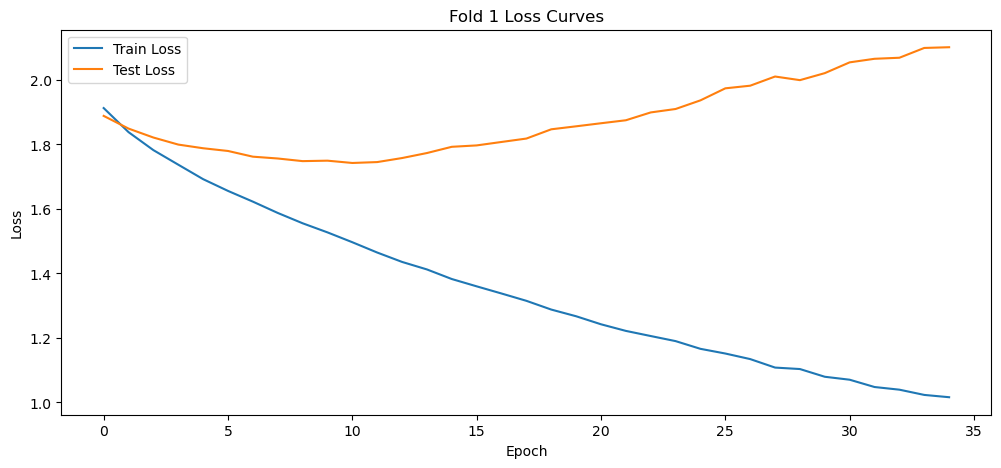

Initialising Model...
Training on actors: [1 2 3 4 6]
Testing on actor: [5]

Fold 2/6
Epoch 1: Train Loss = 1.9246, Test Loss = 1.9084
Epoch 2: Train Loss = 1.8654, Test Loss = 1.8698
Epoch 3: Train Loss = 1.8187, Test Loss = 1.8391
Epoch 4: Train Loss = 1.7792, Test Loss = 1.8144
Epoch 5: Train Loss = 1.7464, Test Loss = 1.7968
Epoch 6: Train Loss = 1.7155, Test Loss = 1.7820
Epoch 7: Train Loss = 1.6889, Test Loss = 1.7678
Epoch 8: Train Loss = 1.6627, Test Loss = 1.7577
Epoch 9: Train Loss = 1.6340, Test Loss = 1.7482
Epoch 10: Train Loss = 1.6099, Test Loss = 1.7410
Epoch 11: Train Loss = 1.5834, Test Loss = 1.7343
Epoch 12: Train Loss = 1.5583, Test Loss = 1.7350
Epoch 13: Train Loss = 1.5358, Test Loss = 1.7342
Epoch 14: Train Loss = 1.5117, Test Loss = 1.7308
Epoch 15: Train Loss = 1.4903, Test Loss = 1.7413
Epoch 16: Train Loss = 1.4652, Test Loss = 1.7446
Epoch 17: Train Loss = 1.4449, Test Loss = 1.7567
Epoch 18: Train Loss = 1.4260, Test Loss = 1.7618
Epoch 19: Train Loss = 

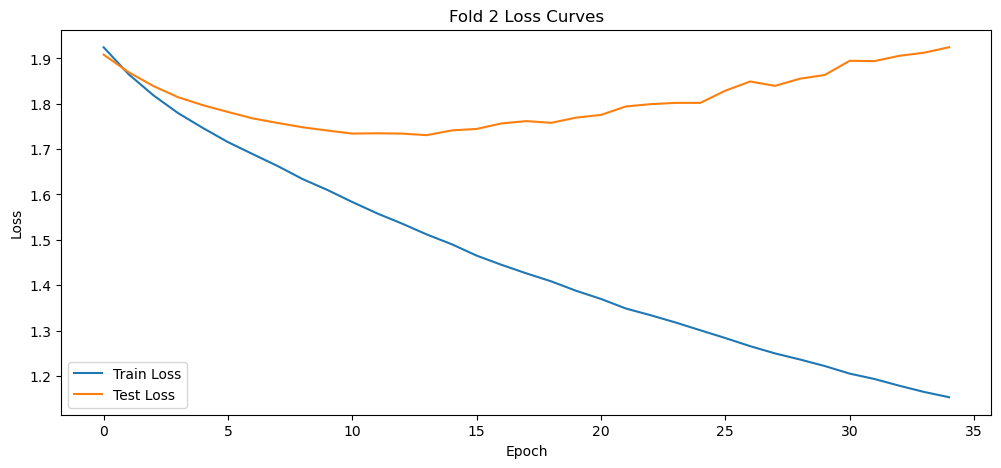

Initialising Model...
Training on actors: [1 2 3 4 5]
Testing on actor: [6]

Fold 3/6
Epoch 1: Train Loss = 1.8866, Test Loss = 1.8625
Epoch 2: Train Loss = 1.8154, Test Loss = 1.8201
Epoch 3: Train Loss = 1.7691, Test Loss = 1.7891
Epoch 4: Train Loss = 1.7326, Test Loss = 1.7641
Epoch 5: Train Loss = 1.7007, Test Loss = 1.7418
Epoch 6: Train Loss = 1.6715, Test Loss = 1.7221
Epoch 7: Train Loss = 1.6438, Test Loss = 1.7037
Epoch 8: Train Loss = 1.6171, Test Loss = 1.6854
Epoch 9: Train Loss = 1.5905, Test Loss = 1.6676
Epoch 10: Train Loss = 1.5653, Test Loss = 1.6523
Epoch 11: Train Loss = 1.5399, Test Loss = 1.6386
Epoch 12: Train Loss = 1.5154, Test Loss = 1.6247
Epoch 13: Train Loss = 1.4919, Test Loss = 1.6117
Epoch 14: Train Loss = 1.4679, Test Loss = 1.5997
Epoch 15: Train Loss = 1.4449, Test Loss = 1.5888
Epoch 16: Train Loss = 1.4223, Test Loss = 1.5782
Epoch 17: Train Loss = 1.4004, Test Loss = 1.5689
Epoch 18: Train Loss = 1.3780, Test Loss = 1.5597
Epoch 19: Train Loss = 

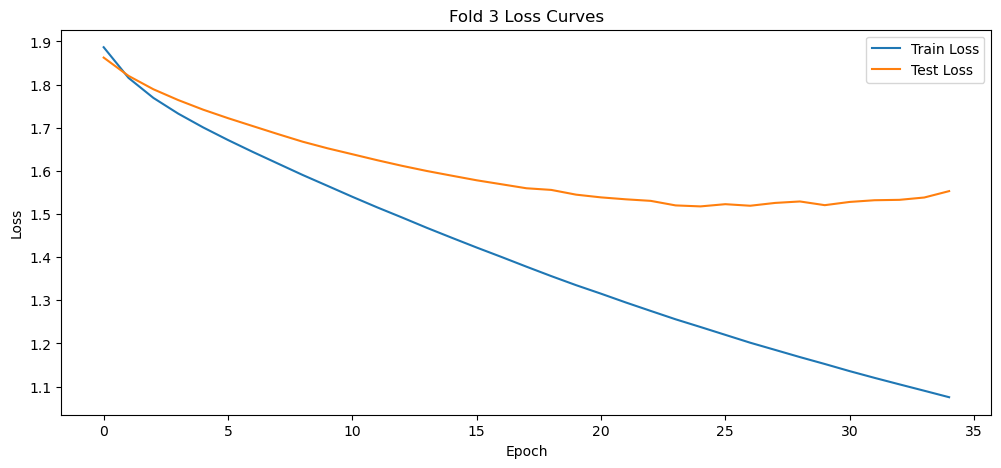

Initialising Model...
Training on actors: [1 2 4 5 6]
Testing on actor: [3]

Fold 4/6
Epoch 1: Train Loss = 1.9246, Test Loss = 1.9082
Epoch 2: Train Loss = 1.8457, Test Loss = 1.8577
Epoch 3: Train Loss = 1.7941, Test Loss = 1.8201
Epoch 4: Train Loss = 1.7503, Test Loss = 1.7887
Epoch 5: Train Loss = 1.7165, Test Loss = 1.7592
Epoch 6: Train Loss = 1.6853, Test Loss = 1.7354
Epoch 7: Train Loss = 1.6602, Test Loss = 1.7089
Epoch 8: Train Loss = 1.6337, Test Loss = 1.6868
Epoch 9: Train Loss = 1.6110, Test Loss = 1.6635
Epoch 10: Train Loss = 1.5813, Test Loss = 1.6452
Epoch 11: Train Loss = 1.5580, Test Loss = 1.6213
Epoch 12: Train Loss = 1.5411, Test Loss = 1.5976
Epoch 13: Train Loss = 1.5125, Test Loss = 1.5776
Epoch 14: Train Loss = 1.4926, Test Loss = 1.5613
Epoch 15: Train Loss = 1.4644, Test Loss = 1.5411
Epoch 16: Train Loss = 1.4539, Test Loss = 1.5253
Epoch 17: Train Loss = 1.4276, Test Loss = 1.5013
Epoch 18: Train Loss = 1.4098, Test Loss = 1.4912
Epoch 19: Train Loss = 

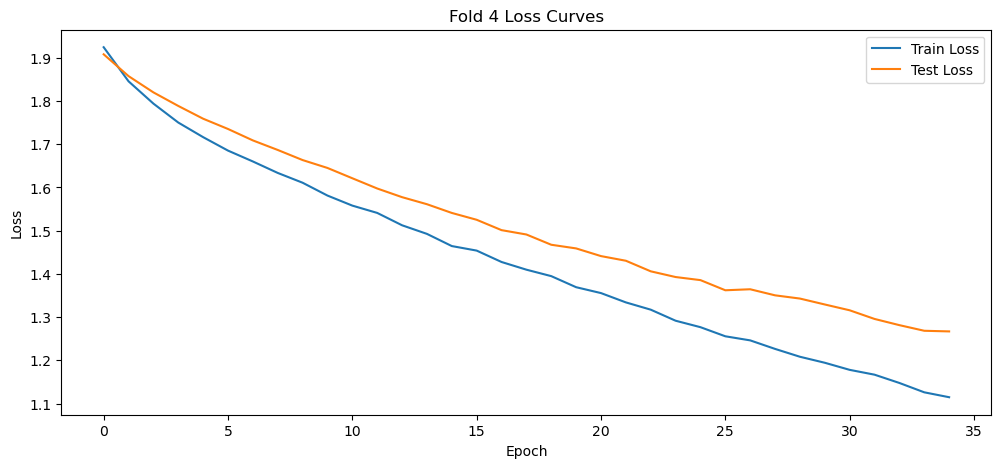

Initialising Model...
Training on actors: [2 3 4 5 6]
Testing on actor: [1]

Fold 5/6
Epoch 1: Train Loss = 1.9011, Test Loss = 1.8856
Epoch 2: Train Loss = 1.8375, Test Loss = 1.8439
Epoch 3: Train Loss = 1.7897, Test Loss = 1.8107
Epoch 4: Train Loss = 1.7479, Test Loss = 1.7843
Epoch 5: Train Loss = 1.7133, Test Loss = 1.7623
Epoch 6: Train Loss = 1.6820, Test Loss = 1.7428
Epoch 7: Train Loss = 1.6511, Test Loss = 1.7258
Epoch 8: Train Loss = 1.6242, Test Loss = 1.7093
Epoch 9: Train Loss = 1.5980, Test Loss = 1.6940
Epoch 10: Train Loss = 1.5712, Test Loss = 1.6803
Epoch 11: Train Loss = 1.5433, Test Loss = 1.6662
Epoch 12: Train Loss = 1.5197, Test Loss = 1.6530
Epoch 13: Train Loss = 1.4977, Test Loss = 1.6399
Epoch 14: Train Loss = 1.4720, Test Loss = 1.6282
Epoch 15: Train Loss = 1.4499, Test Loss = 1.6169
Epoch 16: Train Loss = 1.4264, Test Loss = 1.6064
Epoch 17: Train Loss = 1.4022, Test Loss = 1.5924
Epoch 18: Train Loss = 1.3822, Test Loss = 1.5854
Epoch 19: Train Loss = 

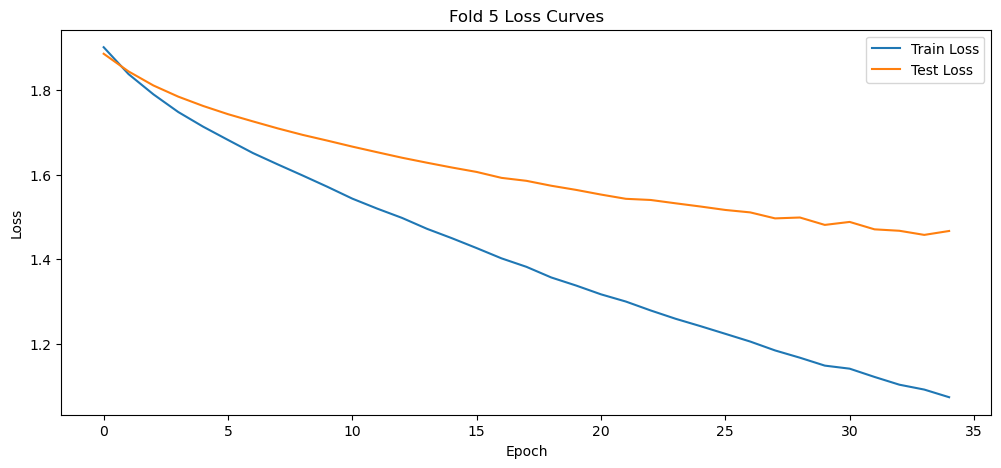

Initialising Model...
Training on actors: [1 2 3 5 6]
Testing on actor: [4]

Fold 6/6
Epoch 1: Train Loss = 1.9143, Test Loss = 1.9068
Epoch 2: Train Loss = 1.8465, Test Loss = 1.8732
Epoch 3: Train Loss = 1.7972, Test Loss = 1.8479
Epoch 4: Train Loss = 1.7563, Test Loss = 1.8271
Epoch 5: Train Loss = 1.7213, Test Loss = 1.8114
Epoch 6: Train Loss = 1.6863, Test Loss = 1.7988
Epoch 7: Train Loss = 1.6560, Test Loss = 1.7879
Epoch 8: Train Loss = 1.6278, Test Loss = 1.7813
Epoch 9: Train Loss = 1.5983, Test Loss = 1.7753
Epoch 10: Train Loss = 1.5695, Test Loss = 1.7704
Epoch 11: Train Loss = 1.5436, Test Loss = 1.7664
Epoch 12: Train Loss = 1.5173, Test Loss = 1.7680
Epoch 13: Train Loss = 1.4918, Test Loss = 1.7597
Epoch 14: Train Loss = 1.4701, Test Loss = 1.7660
Epoch 15: Train Loss = 1.4449, Test Loss = 1.7766
Epoch 16: Train Loss = 1.4217, Test Loss = 1.7776
Epoch 17: Train Loss = 1.4007, Test Loss = 1.7795
Epoch 18: Train Loss = 1.3774, Test Loss = 1.7710
Epoch 19: Train Loss = 

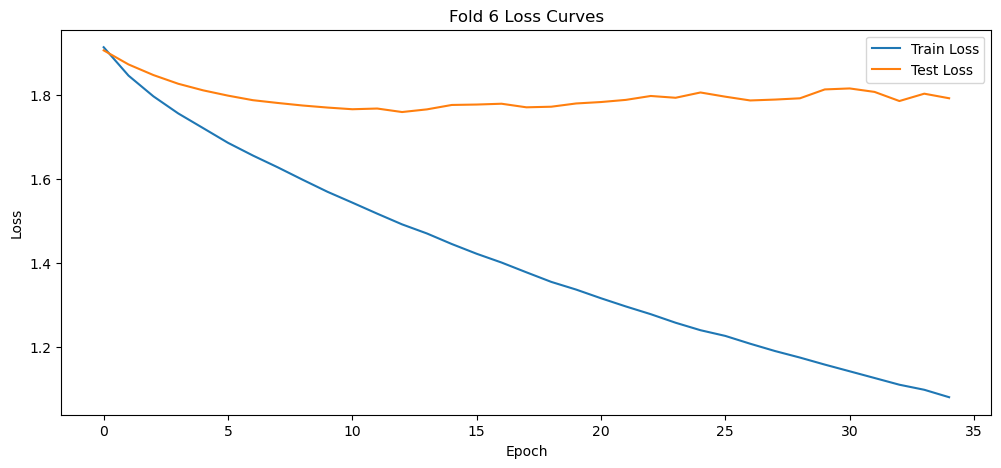

In [86]:
from sklearn.model_selection import GroupKFold
import numpy as np
import matplotlib.pyplot as plt

actor_ids = np.array(full_dataset.get_actor_ids())

# Initialize Leave-One-Actor-Out Cross-Validation
group_kfold = GroupKFold(n_splits=len(np.unique(actor_ids)))

# Loop through splits
for fold, (train_idx, test_idx) in enumerate(group_kfold.split(np.zeros(len(actor_ids)), groups=actor_ids)):
    
    print("Initialising Model...")
    model = SimpleEmotionNN().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.001)
    
    print(f"Training on actors: {np.unique(actor_ids[train_idx])}")
    print(f"Testing on actor: {np.unique(actor_ids[test_idx])}")
    # Create subsets for training and testing
    print(f"\nFold {fold + 1}/{len(np.unique(actor_ids))}")
    
    # Print file paths for training and testing sets
    train_files = [full_dataset.samples[i][0] for i in train_idx]
    test_files = [full_dataset.samples[i][0] for i in test_idx]
    
    
    train_subset = Subset(full_dataset, train_idx)
    test_subset = Subset(full_dataset, test_idx)
    
    # Create DataLoaders
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)
    
    train_losses = []
    test_losses = []
    
    model.train()
    for epoch in range(35):  # Adjust epochs as needed
        total_train_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        # Evaluate on test set
        model.eval()
        total_test_loss = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = loss_func(outputs, labels)
                total_test_loss += loss.item()
        
        avg_test_loss = total_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)
        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Test Loss = {avg_test_loss:.4f}")
        

        # Plot loss and accuracy curves for this fold
    plt.figure(figsize=(12, 5))
    
    # Loss plot
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title(f'Fold {fold + 1} Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()  

In [54]:
epochs = 100

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        # images, labels = images.to("cuda"), labels.to("cuda") #for PC
        images, labels = images.to("cpu"), labels.to("cpu") #for laptop
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = loss_func(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    avg_train_loss = running_loss / len(train_loader)
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            # images, labels = images.to("cuda"), labels.to("cuda")  # Use "cuda" if available
            images, labels = images.to("cpu"), labels.to("cpu")  # Use "cuda" if available

            # Forward pass on validation data
            outputs = model(images)
            loss = loss_func(outputs, labels)

            # Accumulate validation loss
            val_loss += loss.item()
    
    # Calculate average validation loss for this epoch
    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")
    
    # plot the loss of training and validation 

Epoch 1/100, Training Loss: 1.7891, Validation Loss: 1.6819
Epoch 2/100, Training Loss: 1.5852, Validation Loss: 1.5147
Epoch 3/100, Training Loss: 1.4036, Validation Loss: 1.3555
Epoch 4/100, Training Loss: 1.2614, Validation Loss: 1.2294
Epoch 5/100, Training Loss: 1.1423, Validation Loss: 1.1295
Epoch 6/100, Training Loss: 1.0407, Validation Loss: 1.0767
Epoch 7/100, Training Loss: 0.9524, Validation Loss: 1.0190
Epoch 8/100, Training Loss: 0.8724, Validation Loss: 0.9575
Epoch 9/100, Training Loss: 0.8300, Validation Loss: 0.8707
Epoch 10/100, Training Loss: 0.7678, Validation Loss: 0.8267
Epoch 11/100, Training Loss: 0.7206, Validation Loss: 0.7898
Epoch 12/100, Training Loss: 0.6785, Validation Loss: 0.7508
Epoch 13/100, Training Loss: 0.6438, Validation Loss: 0.7520
Epoch 14/100, Training Loss: 0.6204, Validation Loss: 0.7251
Epoch 15/100, Training Loss: 0.5818, Validation Loss: 0.7015
Epoch 16/100, Training Loss: 0.5526, Validation Loss: 0.6299
Epoch 17/100, Training Loss: 0.52

In [ ]:
model.eval()

test_loss = 0.0
correct_predictions = 0
total_predictions = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to("cpu"), labels.to("cpu") #cuda for PC
        # images, labels = images.to("cuda"), labels.to("cuda") #cuda for PC
        
        outputs = model(images)
        
        loss = loss_func(outputs, labels)
        test_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

avg_test_loss = test_loss / len(test_loader)
test_accuracy = correct_predictions/total_predictions

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.1847, Test Accuracy: 0.9356
